### Steps:
- Adapt both normal and noisy logs based on given threshold and adaptation actions
- Encode traces and save an encoded 

In [144]:
# first time to create venv and install packages

# %conda create -n selg-dev anaconda -y
# %conda activate selg-dev -y

# %conda install -n selg-dev pandas -y

# %conda install pip
# %pip install pm4py

# !arch -arm64 brew install graphviz
# !brew install graphviz


In [12]:
import time

# get the start time
start_time_code = time.process_time()

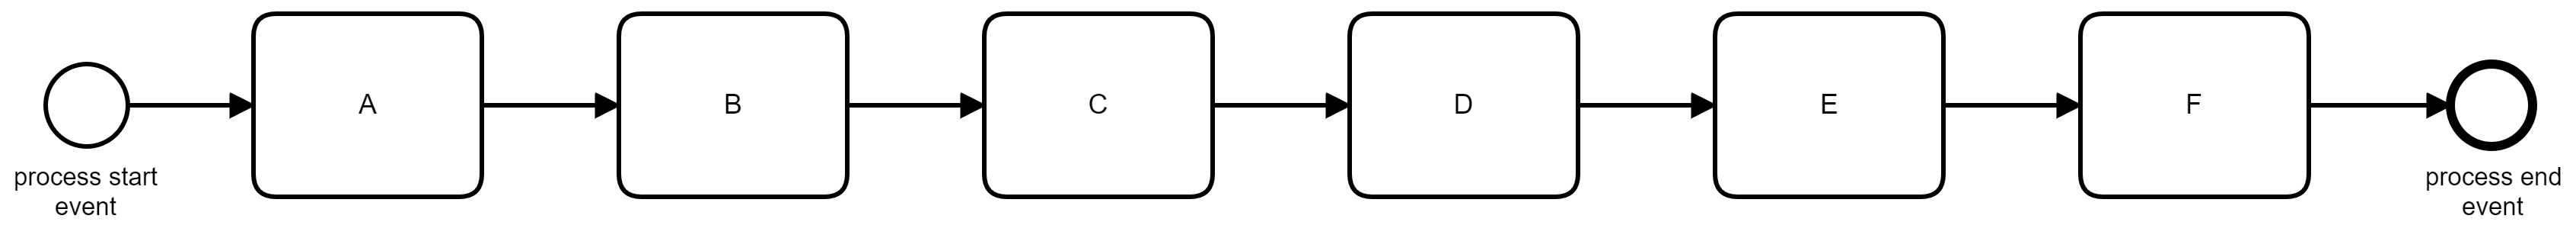

In [13]:
from IPython.display import Image

SKIP_ACTIVITY, INSERT_ACTIVITY, REPEAT_ACTIVITY = 'skip-activity', 'insert-activity', 'repeat-activity'
ADAPTATIONS = [SKIP_ACTIVITY, INSERT_ACTIVITY, REPEAT_ACTIVITY]

ADAPTATION_TYPE = SKIP_ACTIVITY
LOGS_DIR = './logs/'
LOG_NAME = 'sample_sequence_simulation_logs'
LOG_PATH = LOGS_DIR + LOG_NAME + '.xes'
TRANSFORMED_LOG_PATH = LOGS_DIR + LOG_NAME + '_transformed.xes'

raw_data_file_name = LOGS_DIR + LOG_NAME + '_adapted_multi.csv'
noisy_data_file_name = LOGS_DIR + LOG_NAME + '_adapted_noisy_multi.csv'

raw_data_object_file_path = LOGS_DIR + LOG_NAME + '_event_logs_patterned.pickle'
noisy_data_object_file_path = LOGS_DIR + LOG_NAME + '_event_logs_noisy.pickle'

Image(filename=LOGS_DIR + 'sample_sequence.png') 

In [14]:
def read_obj_from_file(file_path):
    import pickle
    file_to_read = open(file_path, "rb")
    loaded_object = pickle.load(file_to_read)
    file_to_read.close()
    return loaded_object

event_logs_patterned = read_obj_from_file(raw_data_object_file_path)
noisy_logs = read_obj_from_file(noisy_data_object_file_path)


### Inject patterns (Update duration of A with some patterns)

In [15]:
def store_obj_in_file(obj, file_path):
    import pickle
    file_to_store = open(file_path, "wb")
    pickle.dump(obj, file_to_store)
    file_to_store.close()

def shift_consecutive_events(trace_events, event_index, time_shift):
    #shift all timestamps after this event
    for ev_index, ev in enumerate(trace_events):
        if ev_index > event_index:
            ev['start_time'] += time_shift
            ev['end_time'] += time_shift

# Inject a pattern to activity A 
def generate_patterned_logs(logs):
    from datetime import timedelta
    import copy

    start_time_patterned_logs = time.process_time()

    # patterns in task durations in minutes
    activities_with_pattern = ['A']
    a_list = [10,20,30,40,30,20]
    patterns = {'A':a_list}

    event_logs_patterned = copy.deepcopy(logs)

    num_traces = len(event_logs_patterned)

    for trace in event_logs_patterned:
        
        trace_events = trace['events']

        for event_index, event in enumerate(trace_events):

            activity_name = event['name']
            trace_id = trace['trace_id']
            
            old_duration = event['end_time'] - event['start_time']
            new_duration_minutes = old_duration.total_seconds()/60

            # assign cycle_times with patterns if patterned task
            if activity_name in activities_with_pattern:
                pattern_length = len(patterns[activity_name])
                new_duration_minutes = patterns[activity_name][trace_id % pattern_length]
            
            new_duration = timedelta(minutes=new_duration_minutes)

            #shift end time of this event
            time_shift = new_duration - old_duration
            event['end_time'] = event['end_time'] + time_shift

            shift_consecutive_events(trace_events, event_index, time_shift)

    end_time_patterned_logs = time.process_time()
    print('Patterned logs generation CPU time:', end_time_patterned_logs - start_time_patterned_logs, 'seconds')
    return event_logs_patterned

event_logs_patterned_A = generate_patterned_logs(event_logs_patterned)
store_obj_in_file(event_logs_patterned_A, raw_data_object_file_path)

Patterned logs generation CPU time: 0.15111399999999975 seconds


### Add noise to patterned logs and save as a separate noisy logs

In [16]:
start_time_adding_noise = time.process_time()

import random
random.seed(10)
noise_percentage_max = 20

def add_noise(logs):
    from datetime import timedelta
    from statistics import mean
    import copy
    
    noise_values = []

    noisy_logs = copy.deepcopy(logs)

    for trace in noisy_logs:
        
        trace_events = trace['events']

        for event_index, event in enumerate(trace_events):

            activity_name = event['name']
            trace_id = trace['trace_id']
            
            # update activity duration
            old_duration = event['end_time'] - event['start_time']
            new_duration_minutes = old_duration / timedelta(minutes=1)

            noise = random.uniform(-new_duration_minutes, new_duration_minutes) * random.uniform(0, noise_percentage_max / 100) # +-[0-noise_percentage]
            new_duration_minutes += noise

            noise_values.append(abs(noise))

            new_duration = timedelta(minutes=new_duration_minutes)

            #shift end time of this event
            time_shift = new_duration - old_duration
            event['end_time'] = event['end_time'] + time_shift

            shift_consecutive_events(trace_events, event_index, time_shift)
        
    print('noise absolute values mean:', mean(noise_values))
                    
    return noisy_logs

noisy_logs_A = add_noise(event_logs_patterned_A)

end_time_adding_noise = time.process_time()
print('Adding noise CPU time:', end_time_adding_noise - start_time_adding_noise, 'seconds')

store_obj_in_file(noisy_logs_A, noisy_data_object_file_path)

noise absolute values mean: 3.227442164398085
Adding noise CPU time: 0.16039499999999984 seconds


### Adapt traces using the time threshold

In [17]:
def adaptation_action_skip(trace, parameters):
    # this implementation skips the skippable activity in a given trace
    for event_index, event in enumerate(trace['events']):
        if event['name'] == parameters['skippable_activity_name']:
            skippable_activity_duration = event['end_time'] - event['start_time']
                    #update consequent timestamps
            time_shift = skippable_activity_duration
            shift_consecutive_events(trace, event_index, time_shift)
                    #remove activity from the events
            trace['events'].pop(event_index)

def adaptation_action_insert(trace, parameters):
    # this implementation inserts the insertable activity in a given trace based after a given point
    for event_index, event in enumerate(trace['events']):
        
        if event['name'] == parameters['insert_after']:
            # add insertable activity after it

            time_shift = parameters['insertable_activity_duration']
            shift_consecutive_events(trace, event_index, time_shift)

            activity = dict()
            activity['name'] = parameters['insertable_activity_name']
            activity['start_time'] = event['end_time']
            activity['end_time'] = event['end_time'] + parameters['insertable_activity_duration']
            activity['resource'] = parameters['insertable_activity_resource']

            trace['events'].insert(event_index + 1, activity)            

def adaptation_action_shorten(trace, parameters, event_name):
    # This implementation shortens the task by reducing the duration of the task
    for event_index, event in enumerate(trace['events']):
        if event['name'] == event_name:
            event['resource'] = parameters['shorten_activity_resource']
            activity_duration = event['end_time'] - event['start_time']
            shortened_duration = parameters['shorten_activity_duration']
            time_shift =  activity_duration - shortened_duration

            event['end_time'] -= time_shift  
            shift_consecutive_events(trace, event_index, -time_shift)
            

def adaptation_action_extend(trace, parameters, event_name):
    # This implementation extends the duration of the specified activity in the task
    for event_index, event in enumerate(trace['events']):
        if event['name'] == event_name:
            event['resource'] = parameters['extending_activity_resource']
            activity_duration = event['end_time'] - event['start_time']
            extended_duration = parameters['extending_activity_duration']
            time_shift = extended_duration - activity_duration
            event['end_time'] += time_shift
            shift_consecutive_events(trace, event_index, time_shift)
            

            
def adaptation_action_repeat(trace, parameters, event_name):
    # This implementation repeats the task if the logged time is too short
    accumulated_task_duration = timedelta()
    idx = 0;
    for event_index, event in enumerate(trace['events']):
        
        if event['name'] == event_name:
            repeatable_activity_duration = event['end_time'] - event['start_time']
            accumulated_task_duration += repeatable_activity_duration
            
            
            if accumulated_task_duration < timedelta(minutes=20) and accumulated_task_duration > timedelta():
                time_shift = repeatable_activity_duration
                shift_consecutive_events(trace['events'], event_index, time_shift)

                activity = dict()
                activity['name'] = 'A'
                activity['start_time'] = event['end_time']
                activity['end_time'] = event['end_time'] + repeatable_activity_duration
                activity['resource'] = parameters['repeatable_activity_resource']

                trace['events'].insert(event_index + 1, activity)



def take_action(trace, parameters):

    trace_events = trace['events']
    trace_cycle_time = trace_events[-1]['end_time'] - trace_events[0]['start_time']
    

    # set adaptation action
    trace['adaptation_action'] = 'no-action'
    
    
    # Take adaptation action with a different condition (priority)
        # Condition - cycle time of trace is too long  -> skip action
    if trace_cycle_time > parameters['cycle_time_threshold']:
        adaptation_action_skip(trace, parameters)
        trace['adaptation_action'] = 'skip'
        # Condition - cycle time of trace is too short -> insert action
    elif trace_cycle_time < parameters['cycle_time_min']:
        adaptation_action_insert(trace, parameters)
        trace['adaptation_action'] = 'insert'
    else:
        for event_index, event in enumerate(trace_events):
            event_duration = event['end_time'] - event['start_time']

                # Condition - duration time of the task is too long  -> shorten action
            if event_duration > parameters['task_duration_threshold']:
                adaptation_action_shorten(trace, parameters, event['name'])
                trace['adaptation_action'] = 'shorten'
                break
                # Condition - duration time of the task is too short  -> repeat action
            elif event_duration < parameters['task_duration_min'] and event_duration > timedelta():
                adaptation_action_repeat(trace, parameters, event['name'])
                trace['adaptation_action'] = 'repeat'
                break
                # Condition - duration time of the task is too short but certain task (C) -> extend action
            elif event['name'] == 'C' and event_duration < parameters['task_duration_C_min']:
                adaptation_action_extend(trace, parameters, event['name'])
                trace['adaptation_action'] = 'extend'
                break
    return trace['adaptation_action']


def adapt_logs(logs, parameters):

    num_traces = len(logs)
    num_adapted_traces = 0
    
    
    for trace in logs:
        adaptation_action = take_action(trace, parameters)
        # do the adaptation if the threshold is violated 
        if adaptation_action != 'no-action':
            num_adapted_traces += 1

    print('Adapted traces percentage:', 100 * num_adapted_traces/num_traces)
    return logs



from datetime import timedelta

parameters = dict()

parameters['cycle_time_threshold'] = timedelta(hours=4, minutes=10)
parameters['skippable_activity_name'] = 'E'

parameters['cycle_time_min'] = timedelta(hours=3, minutes=15)
parameters['insertable_activity_name'] = 'I'
parameters['insertable_activity_duration'] = timedelta(minutes=20)
parameters['insertable_activity_resource'] = 'Inserted_Activity_resource'
parameters['insert_after'] = 'F'

parameters['task_duration_min'] = timedelta(minutes=20)
parameters['repeatable_activity_resource'] = 'Repeated_Activity_resource'

parameters['task_duration_threshold'] = timedelta(minutes=45)
parameters['shorten_activity_duration'] = timedelta(minutes=30)
parameters['shorten_activity_resource'] = 'Shorten_Activity_resource'

parameters['task_duration_C_min'] = timedelta(minutes=40)
parameters['extending_activity_duration'] = timedelta(minutes=60)
parameters['extending_activity_resource'] = 'Extending_Activity_resource'

event_logs_adapted = adapt_logs(event_logs_patterned, parameters)
noisy_logs_adapted = adapt_logs(noisy_logs, parameters)

Adapted traces percentage: 100.0
Adapted traces percentage: 100.0


In [18]:
def logs_to_dict(logs):

    from datetime import timedelta
    all_events = []

    for trace in logs:
        
        trace_events = trace['events']

        for event_index, event in enumerate(trace_events):
            event_dict = {'trace_id':trace['trace_id']}
            event_dict['event_name'] = event['name']
            event_dict['start_time'] = event['start_time']
            event_dict['start_weekday'] = event['start_time'].weekday()
            event_dict['end_time'] = event['end_time']
            event_dict['duration'] = (event['end_time'] - event['start_time']) / timedelta(minutes=1)
            event_dict['resource'] = 'NA' if event['resource'] == None else event['resource']
            event_dict['adaptation_action'] = trace['adaptation_action']
            all_events.append(event_dict)
    
    return all_events

### store logs to csv files (adapted.csv and adapted_noisy.csv)

In [19]:
def write_to_file_csv(file_name, data_dic):
    import csv

    with open(file_name, mode='w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames = list(data_dic[0].keys()))
        writer.writeheader()
        writer.writerows(data_dic)

raw_data = logs_to_dict(event_logs_adapted)
write_to_file_csv(raw_data_file_name, raw_data)

noisy_data = logs_to_dict(noisy_logs_adapted)
write_to_file_csv(noisy_data_file_name, noisy_data)

### Encode data (from events of traces to data rows, each trace -> one row)

In [ ]:
def encode_data(input_csv_file_name, output_csv_file_name):
    import pandas as pd
    import pm4py
    from pm4py.algo.transformation.log_to_features import algorithm as log_to_features
    from datetime import timedelta

    print('Encoding logs to:', output_csv_file_name)

    dataframe = pd.read_csv(input_csv_file_name, sep=',')
    dataframe = pm4py.format_dataframe(dataframe, case_id='trace_id', activity_key='event_name', 
                                        start_timestamp_key='start_time', timestamp_key='end_time')
    event_log = pm4py.convert_to_event_log(dataframe)

    data, feature_names = log_to_features.apply(event_log)

    df = pd.DataFrame(data, columns=feature_names)
    
    cycle_times = []

    grouped_traces = dataframe.groupby(by='trace_id')
    for name, group in grouped_traces:
        trace_cycle_time = (group.iloc[-1]['end_time'] - group.iloc[0]['start_time']) / timedelta(minutes=1)
        cycle_times.append(trace_cycle_time)

    # traces_data = pd.concat([dataframe.groupby(by='trace_id').head(1)['start_time'].sort_values(ascending=True).reset_index(drop=True), dataframe.groupby(by='trace_id').tail(1)['end_time'].sort_values(ascending=True).reset_index(drop=True)], axis=1, keys=['start', 'end'])
    # traces_data['duration'] = traces_data['end'] - traces_data['start']
    
    df['trace:cycle_time'] = cycle_times
    df['adaptation_action'] = dataframe.groupby(by='trace_id')['adaptation_action'].min()
    # print(df['adaptation_action'])
    df.index.name = 'trace_id'

    df.to_csv(output_csv_file_name)

raw_data_encoded_output_file_name = LOGS_DIR + LOG_NAME + '_multi_adapted_encoded.csv'
noisy_data_encoded_output_file_name = LOGS_DIR + LOG_NAME + '_multi_adapted_noisy_encoded.csv'

encode_data(raw_data_file_name, raw_data_encoded_output_file_name)
encode_data(noisy_data_file_name, noisy_data_encoded_output_file_name)
print('Encoding done!')

Encoding logs to: ./logs/sample_sequence_simulation_logs_multi_adapted_encoded.csv


/var/folders/6p/gz1x4wvs4_s9v3lz9n___1_m0000gn/T/ipykernel_35103/2792420634.py:10: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  dataframe = pm4py.format_dataframe(dataframe, case_id='trace_id', activity_key='event_name',
/Users/siheonlee/opt/anaconda3/lib/python3.9/site-packages/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


Encoding logs to: ./logs/sample_sequence_simulation_logs_multi_adapted_noisy_encoded.csv


/var/folders/6p/gz1x4wvs4_s9v3lz9n___1_m0000gn/T/ipykernel_35103/2792420634.py:10: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  dataframe = pm4py.format_dataframe(dataframe, case_id='trace_id', activity_key='event_name',
/Users/siheonlee/opt/anaconda3/lib/python3.9/site-packages/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


### Validation

In [ ]:
def measure_log_fitness_percentage(logs):
    import pm4py

    net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(logs)
    pm4py.view_petri_net(net, initial_marking, final_marking)

    replayed_traces = pm4py.conformance_diagnostics_token_based_replay(logs, net, initial_marking, final_marking)

    num_traces_in_logs = len(logs)
    num_traces_fit = 0

    for replayed_trace in replayed_traces:
        if replayed_trace['trace_is_fit'] == True:
            num_traces_fit += 1
    
    return (num_traces_fit * 100) / num_traces_in_logs

In [ ]:
import pm4py

transformed_logs = pm4py.read_xes(TRANSFORMED_LOG_PATH)
transformed_logs_fitness_percentage = measure_log_fitness_percentage(transformed_logs)
print('Transformed logs fitness percentage:', transformed_logs_fitness_percentage)


In [ ]:
def measure_fitness_percentage_csv_file(log_path):
    import pandas as pd
    import pm4py

    dataframe = pd.read_csv(log_path)
    dataframe = pm4py.format_dataframe(dataframe, case_id='trace_id', activity_key='event_name', timestamp_key='end_time')
    event_logs = pm4py.convert_to_event_log(dataframe)
    fitness_percentage = measure_log_fitness_percentage(event_logs)
    return fitness_percentage

print('Raw logs fitness percentage:', measure_fitness_percentage_csv_file(raw_data_file_name))
print('Noisy logs fitness percentage:', measure_fitness_percentage_csv_file(noisy_data_file_name))

In [ ]:
# get the end time
end_time_code = time.process_time()

# get CPU time
cpu_time = end_time_code - start_time_code
print('CPU Execution time:', cpu_time, 'seconds')